In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer

%matplotlib inline

In [2]:
pd.plotting.register_matplotlib_converters()

In [3]:
forex = pd.read_csv('prep_forex.csv', header=[0,1], index_col=0)
index = pd.read_csv('prep_index.csv', header=[0,1,2], index_col=0)

In [4]:
cd_features = {"BDT": [None, "VND", ("IDR", "IDX Composite")], 
               "MNT": [None, "LKR", ("NZD", "NZX MidCap")],
               ('PKR', 'Karachi 100'): [None, "INR", ('JPY', 'NIkkei 225')],
               ('LKR', 'CSE All-Share'): [None, "IDR", ('MNT', 'MNE Top 20')]}

In [27]:
tran = None
shuffle = False

metric = 'Close_Ret'
metrics = ['Open', 'Close', 'Low', 'High']
target = [metric]
features = ['Intraday_HL', 'Intraday_OC', 'Prev_close_open'] + [y+x for x in ['_Ret', '_Ret_MA_3', '_Ret_MA_15', '_Ret_MA_45', '_MTD', '_YTD'] for y in metrics]# if (x+y) not in target]
scalers = [MinMaxScaler, StandardScaler, FunctionTransformer]


In [6]:
def split_scale(X, y, scaler, shuffle=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=shuffle, test_size=0.2)
    print(y_test.tail())
    if(scaler is None):
        return(X_train, X_test, y_train, y_test)
    else:
        scaler_X = scaler()
        if(scaler == scalers[-1]):
            scaler_X = scaler(np.log1p)
        scaler_X = scaler_X.fit(X_train)
        X_train = scaler_X.transform(X_train)
        X_test = scaler_X.transform(X_test)
        scaler_y = scaler()
        if(scaler == scalers[-1]):
            scaler_y = scaler(np.log1p)
        scaler_y = scaler_y.fit(y_train)
        y_train = scaler_y.transform(y_train)
        y_test = scaler_y.transform(y_test)
        print(y_test.tail())
        return(X_train, X_test, y_train, y_test)

In [7]:
def add_cross_domain_features(feat):
    if(isinstance(feat, tuple)):
        index_cols = index_cols = [x for x in index.columns if x[1] == feat[0] and x[2] == feat[1]]
        X = index[[col for col in index_cols if col[0] in features + ['Time features']]][:-1]
    else:
        forex_cols = [x for x in forex.columns if x[1] == feat]
        X = forex[[col for col in forex_cols if col[0] in features + ['Time features']]][:-1]
    return(X)

In [8]:
def get_feats_targets(cur, extra_feat):
    if(isinstance(cur, tuple)):
        index_cols = [x for x in index.columns if x[1] == cur[0] and x[2] == cur[1]]
        X = index[[col for col in index_cols if col[0] in features + ['Time features']]][:-1]
        y = index[[col for col in index_cols if col[0] in target]].shift(-1)[:-1]
        if(extra_feat):
            X = X.join(add_cross_domain_features(extra_feat))
        X = X.dropna(how='all', axis=1)
    else:
        forex_cols = [x for x in forex.columns if x[1] == cur]
        X = forex[[col for col in forex_cols if col[0] in features + ['Time features']]][:-1]
        y = forex[[col for col in forex_cols if col[0] in target]].shift(-1)[:-1]
        if(extra_feat):
            X = X.join(add_cross_domain_features(extra_feat))
        X = X.dropna(how='all', axis=1)
    X_train, X_test, y_train, y_test = split_scale(X, y, tran, shuffle)
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    return(X_train, X_test, y_train, y_test)

In [9]:
def prep_y_train(y_train):
    y_train = y_train.reset_index()
    y_train.columns = ['ds', 'y']
    return(y_train)

In [10]:
def call_prophet(y_train, regress=False, X_train = None, X_test = None):
    m = Prophet()
#     m.add_seasonality(name='yearly', period='10', fourier_order=10)
    if(regress):
        exog = X_train
        exog.columns = [str(x) for x in list(exog.columns)]
        X_test.columns = [str(x) for x in list(X_test.columns)]
        exog = exog.reset_index(drop=True)
        for c in exog.columns:
            m.add_regressor(c)
        m.fit(y_train.join(exog))
    else:
        m.fit(y_train)
    future = pd.DataFrame(X_train.append(X_test).index)
    future.columns = ['ds']
    if(regress):
        temp = X_train.append(X_test)
        temp.columns = [str(x) for x in list(temp.columns)]
        temp = temp.reset_index(drop=True)
        future = future.join(temp)
    # future['cap'] = 8
    forecast = m.predict(future)
    m.plot(forecast)
    return(forecast)

In [11]:
def gen_res(y, forecast):
    forecast = forecast[forecast['ds'].isin(y.index)]
    print(forecast.shape, y.shape)
    res = y.join(forecast.set_index('ds')['yhat'])
    res.columns = ['y_true', 'y_pred']
    res.plot()
    return(res)

In [12]:
def save_res(res):
    if(target[0][-3:] == 'Ret'):
        ret_res = np.sign(res)
    else:
        ret_res = np.sign(res.pct_change())
    to_save = pd.concat([ret_res, res], axis=1)
    to_save.columns = ['y_true_class', 'y_pred_class', 'y_true_reg', 'y_pred_reg']
#     print(to_save.head())
    return(to_save)

In [ ]:
confusion_matrix(y_true = ret_res['y_true'][1:], y_pred = ret_res['y_pred'][1:])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           Close_Ret
Currency         BDT
Date                
2019-12-24  0.000000
2019-12-25  0.000943
2019-12-26  0.000000
2019-12-27 -0.000412
2019-12-30  0.000000
(2085, 27) (2085, 1)
(522, 27) (522, 1)
(522, 19) (522, 1)
BDT False 0.31591873765933776 -0.02143455366728264 8.371717653744635e-06


C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (2 levels on the left, 1 on the right)



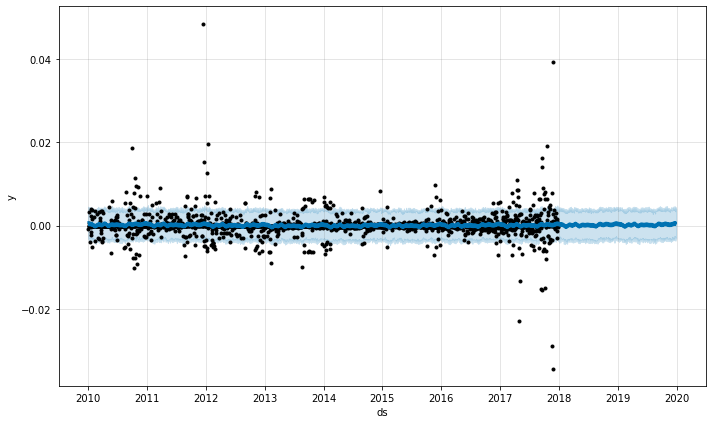

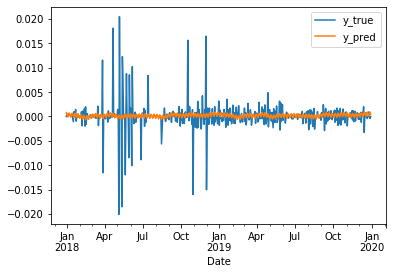

In [28]:
cur='BDT'
regress_extra = False
X_train, X_test, y_train, y_test = get_feats_targets(cur, None)
y_train = prep_y_train(y_train)
forecast = call_prophet(y_train, regress_extra, X_train, X_test)
res = gen_res(y_test, forecast)
ret_res = save_res(res)[1:]
# ret_res.to_csv("Lol_yeh_dekho.csv")
print(cur, regress_extra,
      f1_score(ret_res['y_true_class'], ret_res['y_pred_class'], average='weighted'),
      r2_score(ret_res['y_true_reg'], ret_res['y_pred_reg']),
      mean_squared_error(ret_res['y_true_reg'], ret_res['y_pred_reg']))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             Close
Currency       BDT
Date              
2019-12-24  84.850
2019-12-25  84.930
2019-12-26  84.930
2019-12-27  84.895
2019-12-30  84.895
(2085, 31) (2085, 1)
(522, 31) (522, 1)


C:\Users\shubh31\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in sign

C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (1 levels on the left, 2 on the right)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(522, 19) (522, 1)
BDT True None 0.3114496963874942 -13.819201164851812
             Close
Currency       BDT
Date              
2019-12-24  84.850
2019-12-25  84.930
2019-12-26  84.930
2019-12-27  84.895
2019-12-30  84.895
(2085, 62) (2085, 1)
(522, 62) (522, 1)


C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (2 levels on the left, 1 on the right)

C:\Users\shubh31\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in sign

C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (2 levels on the left, 3 on the right)

C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (1 levels on the left, 2 on the right)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(522, 19) (522, 1)
BDT True VND 0.3114496963874942 -13.819201164851812
             Close
Currency       BDT
Date              
2019-12-24  84.850
2019-12-25  84.930
2019-12-26  84.930
2019-12-27  84.895
2019-12-30  84.895
(2085, 62) (2085, 1)
(522, 62) (522, 1)


C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (2 levels on the left, 1 on the right)

C:\Users\shubh31\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in sign

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(522, 19) (522, 1)
BDT True ('IDR', 'IDX Composite') 0.3114496963874942 -13.819201164851812
             Close
Currency       BDT
Date              
2019-12-24  84.850
2019-12-25  84.930
2019-12-26  84.930
2019-12-27  84.895
2019-12-30  84.895
(2085, 31) (2085, 1)
(522, 31) (522, 1)


C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (2 levels on the left, 1 on the right)

C:\Users\shubh31\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in sign

C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (1 levels on the left, 2 on the right)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(522, 19) (522, 1)
BDT False 0.3114496963874942 -13.819201164851812
             Close
Currency       MNT
Date              
2019-12-24  2730.0
2019-12-25  2721.5
2019-12-26  2721.5
2019-12-27  2733.0
2019-12-30  2735.0
(2085, 31) (2085, 1)
(522, 31) (522, 1)


C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (2 levels on the left, 1 on the right)

C:\Users\shubh31\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in sign

C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (1 levels on the left, 2 on the right)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(522, 19) (522, 1)
MNT True None 0.3516959387219933 -4.199827443072612
             Close
Currency       MNT
Date              
2019-12-24  2730.0
2019-12-25  2721.5
2019-12-26  2721.5
2019-12-27  2733.0
2019-12-30  2735.0
(2085, 62) (2085, 1)
(522, 62) (522, 1)


C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (2 levels on the left, 1 on the right)

C:\Users\shubh31\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in sign

C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (2 levels on the left, 3 on the right)

C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (1 levels on the left, 2 on the right)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(522, 19) (522, 1)
MNT True LKR 0.3516959387219933 -4.199827443072612
             Close
Currency       MNT
Date              
2019-12-24  2730.0
2019-12-25  2721.5
2019-12-26  2721.5
2019-12-27  2733.0
2019-12-30  2735.0
(2085, 62) (2085, 1)
(522, 62) (522, 1)


C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (2 levels on the left, 1 on the right)

C:\Users\shubh31\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in sign

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(522, 19) (522, 1)
MNT True ('NZD', 'NZX MidCap') 0.3516959387219933 -4.199827443072612
             Close
Currency       MNT
Date              
2019-12-24  2730.0
2019-12-25  2721.5
2019-12-26  2721.5
2019-12-27  2733.0
2019-12-30  2735.0
(2085, 31) (2085, 1)
(522, 31) (522, 1)


C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (2 levels on the left, 1 on the right)

C:\Users\shubh31\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in sign

C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (1 levels on the left, 3 on the right)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(522, 19) (522, 1)
MNT False 0.3516959387219933 -4.199827443072612
                 Close
Currency           PKR
Idx        Karachi 100
Date                  
2019-12-24   40728.055
2019-12-25   41127.790
2019-12-26   40848.530
2019-12-27   40887.620
2019-12-30   40735.080
(2085, 31) (2085, 1)
(522, 31) (522, 1)


C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (3 levels on the left, 1 on the right)

C:\Users\shubh31\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in sign

C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (3 levels on the left, 2 on the right)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(522, 19) (522, 1)
('PKR', 'Karachi 100') True None 0.51621448092003 -9.68902973039536
                 Close
Currency           PKR
Idx        Karachi 100
Date                  
2019-12-24   40728.055
2019-12-25   41127.790
2019-12-26   40848.530
2019-12-27   40887.620
2019-12-30   40735.080
(2085, 62) (2085, 1)
(522, 62) (522, 1)


C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (3 levels on the left, 1 on the right)

C:\Users\shubh31\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in sign

C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (1 levels on the left, 3 on the right)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(522, 19) (522, 1)
('PKR', 'Karachi 100') True INR 0.51621448092003 -9.68902973039536
                 Close
Currency           PKR
Idx        Karachi 100
Date                  
2019-12-24   40728.055
2019-12-25   41127.790
2019-12-26   40848.530
2019-12-27   40887.620
2019-12-30   40735.080
(2085, 31) (2085, 1)
(522, 31) (522, 1)


C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (3 levels on the left, 1 on the right)

C:\Users\shubh31\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in sign

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(522, 19) (522, 1)
('PKR', 'Karachi 100') True ('JPY', 'NIkkei 225') 0.51621448092003 -9.68902973039536
                 Close
Currency           PKR
Idx        Karachi 100
Date                  
2019-12-24   40728.055
2019-12-25   41127.790
2019-12-26   40848.530
2019-12-27   40887.620
2019-12-30   40735.080
(2085, 31) (2085, 1)
(522, 31) (522, 1)


C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (3 levels on the left, 1 on the right)

C:\Users\shubh31\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in sign

C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (1 levels on the left, 3 on the right)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(522, 19) (522, 1)
('PKR', 'Karachi 100') False 0.51621448092003 -9.68902973039536
                   Close
Currency             LKR
Idx        CSE All-Share
Date                    
2019-12-24      6069.905
2019-12-25      6086.690
2019-12-26      6122.640
2019-12-27      6156.000
2019-12-30      6129.210
(2085, 31) (2085, 1)
(522, 31) (522, 1)
(522, 19) (522, 1)
('LKR', 'CSE All-Share') True None 0.526720203345142 -2.5276988629716537
                   Close
Currency             LKR
Idx        CSE All-Share
Date                    
2019-12-24      6069.905
2019-12-25      6086.690
2019-12-26      6122.640
2019-12-27      6156.000
2019-12-30      6129.210
(2085, 62) (2085, 1)
(522, 62) (522, 1)


C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (3 levels on the left, 1 on the right)

C:\Users\shubh31\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in sign

C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (3 levels on the left, 2 on the right)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (3 levels on the left, 1 on the right)

C:\Users\shubh31\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in sign

C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\m

(522, 19) (522, 1)
('LKR', 'CSE All-Share') True IDR 0.526720203345142 -2.5276988629716537
                   Close
Currency             LKR
Idx        CSE All-Share
Date                    
2019-12-24      6069.905
2019-12-25      6086.690
2019-12-26      6122.640
2019-12-27      6156.000
2019-12-30      6129.210
(2085, 62) (2085, 1)
(522, 62) (522, 1)


C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (3 levels on the left, 1 on the right)

C:\Users\shubh31\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in sign

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(522, 19) (522, 1)
('LKR', 'CSE All-Share') True ('MNT', 'MNE Top 20') 0.526720203345142 -2.5276988629716537
                   Close
Currency             LKR
Idx        CSE All-Share
Date                    
2019-12-24      6069.905
2019-12-25      6086.690
2019-12-26      6122.640
2019-12-27      6156.000
2019-12-30      6129.210
(2085, 31) (2085, 1)
(522, 31) (522, 1)
(522, 19) (522, 1)
('LKR', 'CSE All-Share') False 0.526720203345142 -2.5276988629716537


C:\Users\shubh31\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning:

merging between different levels can give an unintended result (3 levels on the left, 1 on the right)

C:\Users\shubh31\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in sign



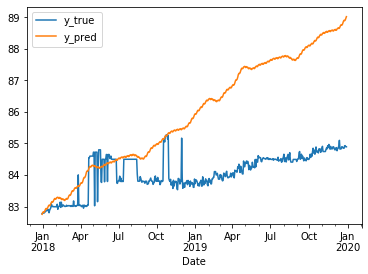

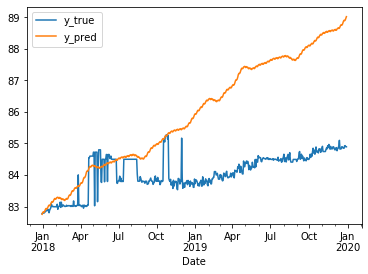

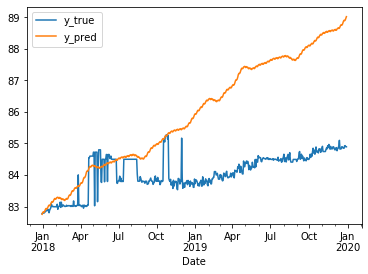

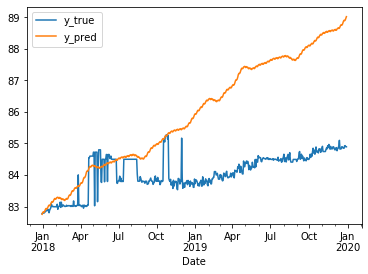

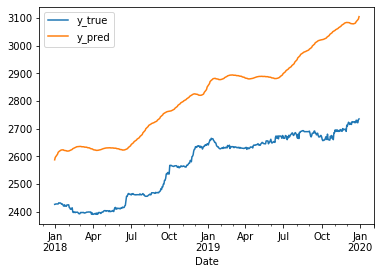

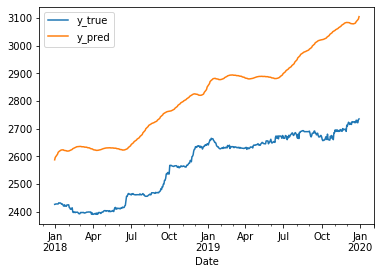

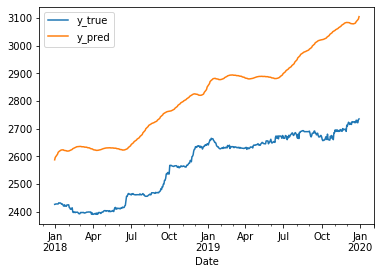

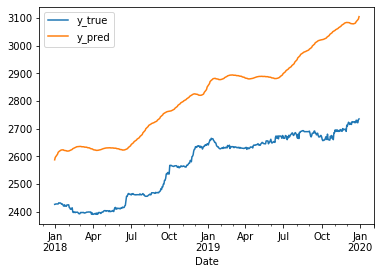

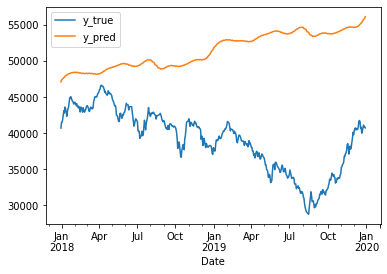

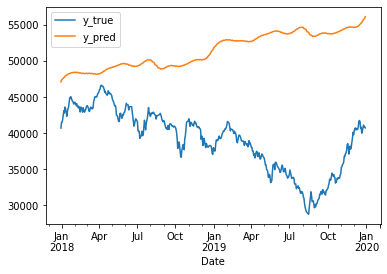

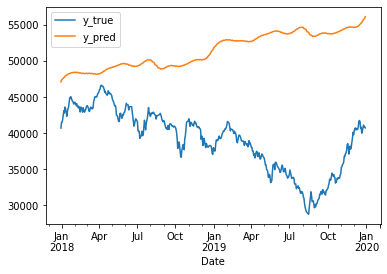

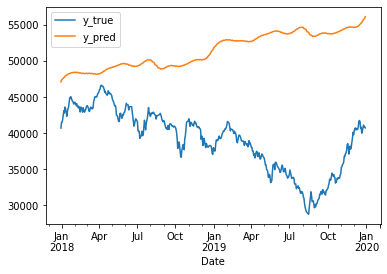

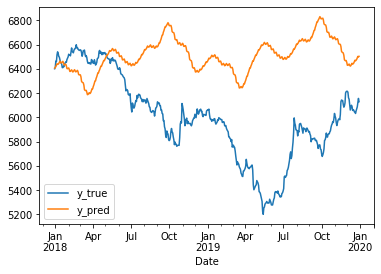

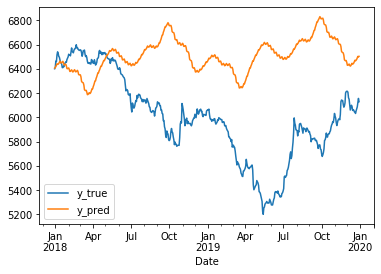

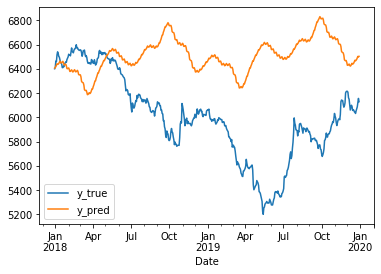

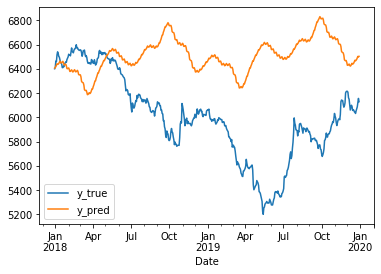

In [25]:
for cur in cd_features:
    for regress_extra in [True, False]:
        if(regress_extra):
            for extra_feat in cd_features[cur]:
                X_train, X_test, y_train, y_test = get_feats_targets(cur, extra_feat)
                y_train = prep_y_train(y_train)
                forecast = call_prophet(y_train, True, X_train, X_test)
                res = gen_res(y_test, forecast)
                ret_res = save_res(res)[1:]
                try:
                    ret_res.to_csv(str(cur)+"_"+str(regress_extra)+"_"+('_'.join(extra_feat))+"_"+target[0]+"_prophet_log.csv")
                except:
                    ret_res.to_csv(str(cur)+"_"+str(regress_extra)+"_"+target[0]+"_prophet.csv")
                print(cur, regress_extra, extra_feat, 
                      f1_score(ret_res['y_true_class'], ret_res['y_pred_class'], average='weighted'),
                      r2_score(ret_res['y_true_reg'], ret_res['y_pred_reg']))
        else:
            X_train, X_test, y_train, y_test = get_feats_targets(cur, None)
            y_train = prep_y_train(y_train)
            forecast = call_prophet(y_train, False, X_train, X_test)
            res = gen_res(y_test, forecast)
            ret_res = save_res(res)[1:]
            ret_res.to_csv(str(cur)+"_"+str(regress_extra)+"_"+target[0]+"_prophet.csv")
            print(cur, regress_extra,
                      f1_score(ret_res['y_true_class'], ret_res['y_pred_class'], average='weighted'),
                      r2_score(ret_res['y_true_reg'], ret_res['y_pred_reg']))